# Plotting results of parameter tuning

In [1]:
from ray import tune, train
import seaborn as sns

def objective(config):
    '''
    this function is to be taken from parameter_tuning.py 
    '''
    models = []
    history = []

    X_, B_ = prep_data(X, B, win=config["win"])
    X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)

    for i in range(5):
        T_Y_options  = {
            'linear': tf.keras.Sequential([
                layers.Dense(latent_dim, activation='linear'),
                layers.Normalization(axis=-1),
            ]),
            'non-linear': tf.keras.Sequential([
                layers.Dense(latent_dim, activation='relu'),
                layers.Dense(2*latent_dim, activation='relu'),
                layers.Dense(latent_dim, activation='linear'),
                layers.Normalization(axis=-1),
            ])
        }
        ### Deploy BunDLe Net
        model = BunDLeNet(latent_dim=3, num_behaviour=B_.shape[1])
        model.build(input_shape=X_.shape)
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
        model.T_Y = T_Y_options[config["T_Y_option"]]

        train_history, test_history = train_model(
            X_train,
            B_train_1,
            model,
            optimizer,
            gamma=0.9, 
            n_epochs=200,
            pca_init=False,
            best_of_5_init=False,
            validation_data = (X_test, B_test_1)
        )       
        models.append(model)
        history.append([train_history, test_history])

    # Choosing best model based on the test loss
    history = np.array(history)
    train_loss = history[:,0,-1,-1]
    test_loss = history[:,1,-1,-1]

    idx_optimal = np.argmin(test_loss)
    model_opt = models[idx_optimal]
    train_loss_opt = train_loss[idx_optimal]
    test_loss_opt = test_loss[idx_optimal]
    train.report({"test_loss":test_loss_opt, "train_loss":train_loss_opt})

/home/akshey/Desktop/PhD/Code_repositories/cebra/env_cebra/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-19 14:33:01,121	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-19 14:33:01,537	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
experiment_path = '~/ray_results/objective_2024-03-06_14-47-23' #objective_2024-03-06_14-47-23, objective_2024-03-05_14-16-24 objective_2024-03-04_14-36-44, objective_2024-03-04_16-06-50, objective_2024-03-04_16-49-04
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=objective)
result_grid = restored_tuner.get_results()

Loading results from ~/ray_results/objective_2024-03-06_14-47-23...


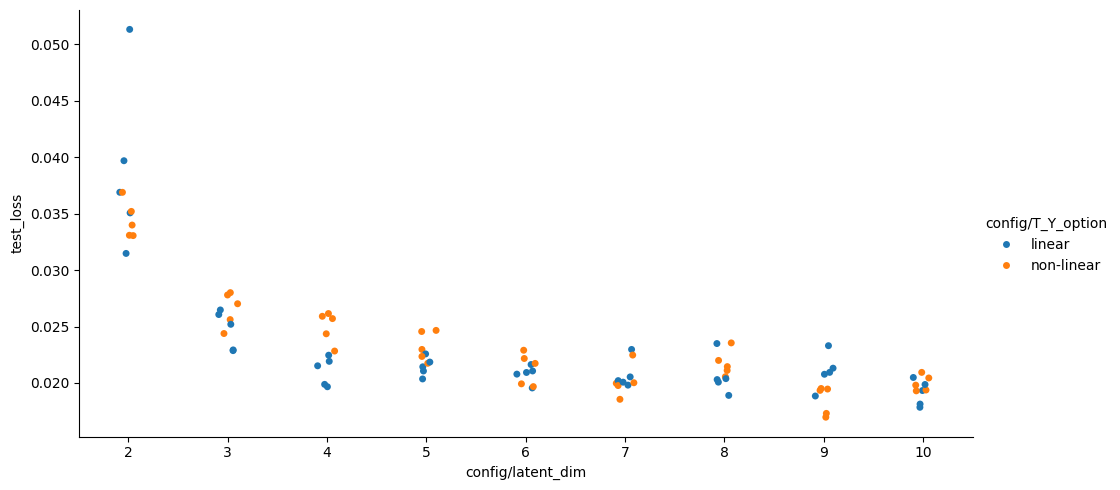

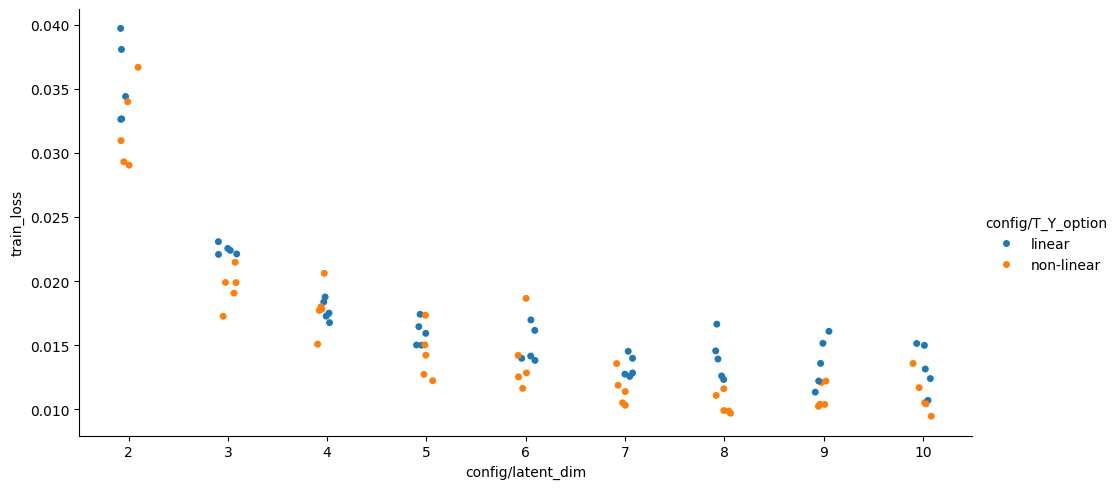

In [3]:
results_df = result_grid.get_dataframe()
sns.catplot(data=results_df, x='config/latent_dim', y='test_loss', hue='config/T_Y_option', aspect=2)
sns.catplot(data=results_df, x='config/latent_dim', y='train_loss', hue='config/T_Y_option', aspect=2)

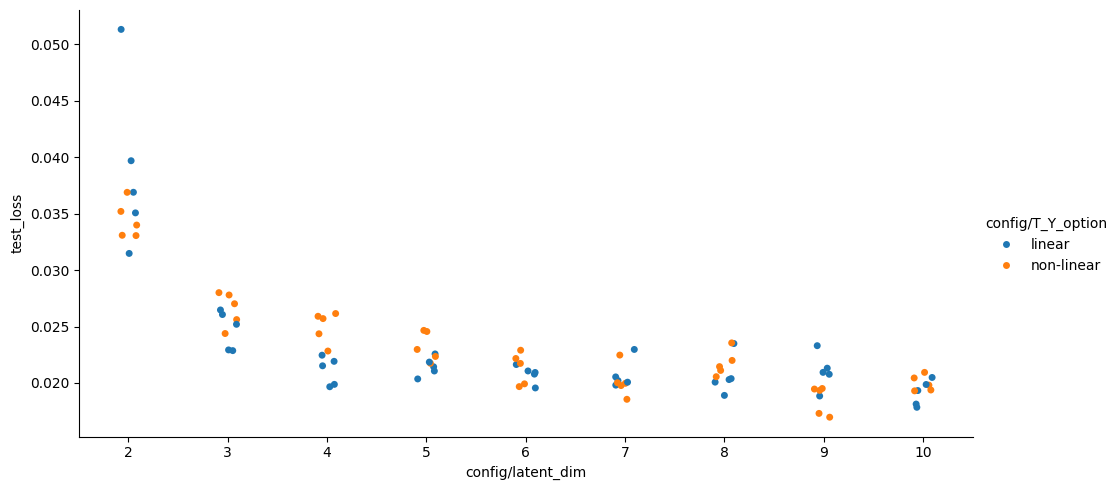

In [4]:
sns.catplot(data=results_df, x='config/latent_dim', y='test_loss', hue='config/T_Y_option', aspect=2)

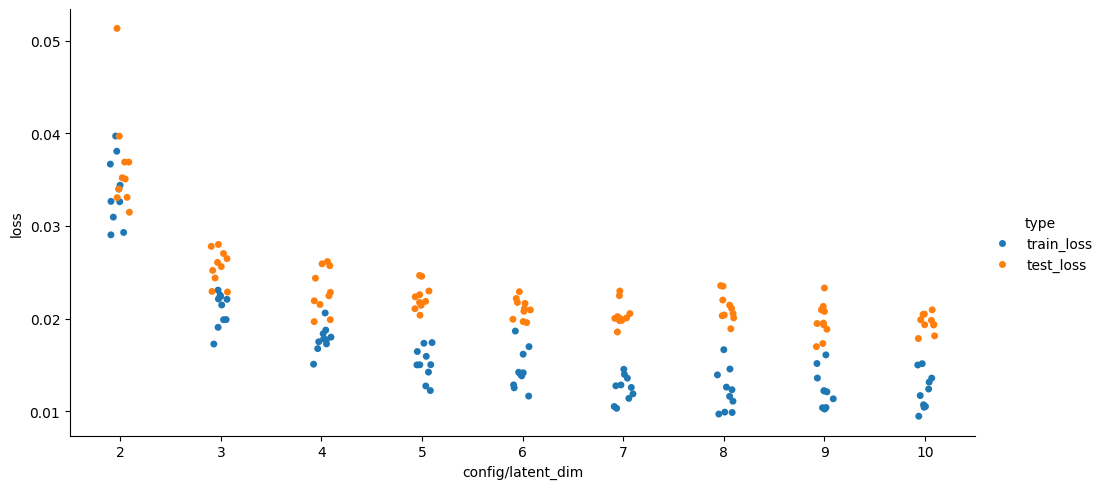

In [5]:
import pandas as pd
results_df_melted = pd.melt(results_df, id_vars=['config/latent_dim'], value_vars=['train_loss', 'test_loss'], var_name='type', value_name='loss')
sns.catplot(data=results_df_melted, x='config/latent_dim', y='loss', hue='type', aspect=2)
